# PRUEBAS


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [3]:
# colores para los gráficos
colores = {
    'estepa':   '#FF6347',  # Rojo anaranjado
    'pino':     '#2E8B57',  # Verde bosque
    'dia':      '#FFA726',  # Naranja suave
    'noche':    '#4169E1',  # Azul royal
    'datos':    '#E2725B',  # Terracota claro
    'trend':    '#2E8B57',  # Verde bosque
    'season':   '#4169E1',  # Azul royal
    'residuo':  '#9E9E9E',  # Gris medio
    'train':    '#9E9E9E',  # Gris medio
    'test':     '#2B2B2B',  # Gris oscuro
    'TRANSFORMER': '#00FA9A',  # Verde menta
    'SARIMA':   '#6A5ACD',  # Lavanda
    'SARIMA_IC':'#C5B4E3',  # Lavanda claro
    'LSTM':     '#E57373'   # Rojo suave
    }

Tenemos tres dataframes con las siguientes series:
- df: toda la información de las LST de los 5 años, para pino y para estepa.
- df_d / df_n: las LST diurna y nocturna respectivamente. Cada df tiene las LST de pino y estepa junto con el delta de estas temperaturas = LST estepa - LST pino.

In [4]:
# Temperaturas diurnas
df_d = pd.read_csv("csv/ts_d.csv", parse_dates=["fecha"],
    dtype={"pino": "float64",
           "estepa": "float64",
           "mes": "int64",
           "delta": "float64"
          })
df_d.head(10)

,fecha,estepa,pino,mes,delta
0,2020-01-01,36.280639,30.976251,1,5.304388
1,2020-01-09,33.107195,26.849177,1,6.258017
2,2020-01-17,40.126597,33.924788,1,6.201808
3,2020-01-25,34.904348,28.310403,1,6.593945
4,2020-02-02,34.400693,27.574299,2,6.826394
5,2020-02-10,30.593728,25.033515,2,5.560213
6,2020-02-18,31.541956,25.955979,2,5.585977
7,2020-02-26,36.649758,31.037088,2,5.612670
8,2020-03-05,30.742659,25.520392,3,5.222267
9,2020-03-13,28.569933,23.153814,3,5.416119


In [5]:
# Temperaturas diurnas (diarias)
df_d_diaria = pd.read_csv("csv/ts_d_diario_imputado.csv", parse_dates=["fecha"],
    dtype={"pino": "float64",
           "estepa": "float64",
           "mes": "int64",
           "delta": "float64"
          })

df_d_diaria.head(10)

,fecha,estepa,pino,mes,delta
0,2020-01-01,35.433453,33.666374,1,1.767079
1,2020-01-02,36.195872,31.342840,1,4.853032
2,2020-01-03,35.245773,31.284172,1,3.961601
3,2020-01-04,38.821326,31.450303,1,7.371023
4,2020-01-05,25.626907,17.944593,1,7.682314
5,2020-01-06,24.419361,19.761171,1,4.658190
6,2020-01-07,25.590980,19.523039,1,6.067942
7,2020-01-08,23.595392,18.317425,1,5.277967
8,2020-01-09,24.220856,18.704153,1,5.516703
9,2020-01-10,27.450967,22.472114,1,4.978853


## 4. Modelos predictivos

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-12-07 10:09:33.682401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# función para crear secuencias
def create_sequences(data, seq_length, target_idx=0):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_idx])
    return np.array(X), np.array(y)


In [55]:
def guardar_estadisticas( modelo, mae, mse, rmse):
    if modelo in df_resultados['Modelo'].values:
        df_resultados.loc[df_resultados['Modelo'] == modelo, [ 'MAE', 'MSE', 'RMSE']] = [mae, mse, rmse]
    else:
        df_resultados.loc[len(df_resultados)] = [modelo, mae, mse, rmse]

# Dataframe para guardar los resultados
df_resultados = pd.DataFrame(columns=['Modelo', 'MAE', 'MSE', 'RMSE'])

### Preparación de datos para entrenamiento

Se entrenarán modelos para dos series distintas:
- delta de temperaturas diarias (train_dia / test_dia)
- delta de temperaturas nocturnas (train_noche / test_noche)

In [8]:
# df_serie = df_d[['fecha','delta']]       # datos cada 8D (producto MODIS)
df_serie = df_d_diaria[['fecha','delta']] # datos diarios sin gaps

df_serie = df_serie.set_index('fecha')
df_serie.index = pd.to_datetime(df_serie.index)
df_serie.head()

,delta
fecha,
2020-01-01,1.767079
2020-01-02,4.853032
2020-01-03,3.961601
2020-01-04,7.371023
2020-01-05,7.682314


In [9]:
train_size = int(len(df_serie) * 0.8)  # 80% entrenamiento, 20% test
train_size

1461

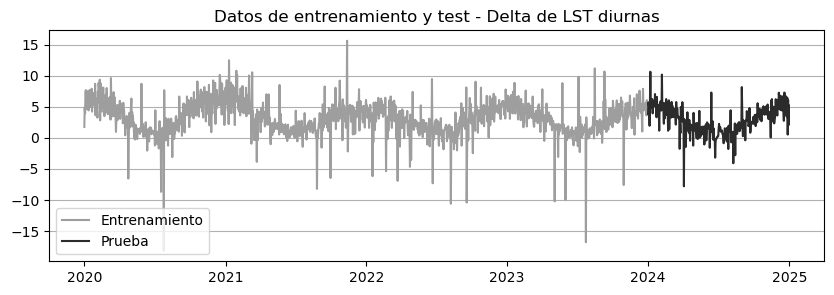

In [10]:
train = df_serie['delta'].iloc[:train_size]
test = df_serie['delta'].iloc[train_size:]

plt.figure(figsize=(10, 3))
plt.plot(train, label='Entrenamiento', color=colores['train'])
plt.plot(test, label='Prueba', color=colores['test'])
#plt.legend()
plt.legend(loc='lower left')

plt.grid(axis='y')
plt.title('Datos de entrenamiento y test - Delta de LST diurnas')
plt.show()

In [11]:
# Cuántos datos hay por año?
train.groupby(train.index.year).count()

fecha
2020    366
2021    365
2022    365
2023    365
Name: delta, dtype: int64

In [12]:
test.groupby(test.index.year).count()

fecha
2024    366
Name: delta, dtype: int64

In [13]:
diff_dias = train.index.to_series().diff().dt.days
diff_dias = diff_dias.to_frame(name='diff')
diff_dias[diff_dias['diff']!=8]

,diff
fecha,
2020-01-01,NaN
2020-01-02,1.0
2020-01-03,1.0
2020-01-04,1.0
2020-01-05,1.0
...,...
2023-12-27,1.0
2023-12-28,1.0
2023-12-29,1.0


### a) LSTM

El modelo LSTM (Long Short-Term Memory) es un tipo de red neuronal recurrente diseñada para capturar dependencias de largo plazo en series temporales. LSTM no requiere que la serie sea estacionaria y puede aprender patrones complejos no lineales en los datos, incluyendo tendencias, estacionalidades y efectos de interacciones pasadas.

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
# Incluimos (opcionalmente) características estacionales (seno y coseno)
df_lstm = df_serie.copy()
use_seasonal_features = False  # False: usar solo el dato delta temperatura
if use_seasonal_features:
    df_lstm['semana_del_año'] = df_lstm.index.isocalendar().week
    df_lstm['sin_semana'] = np.sin(2 * np.pi * df_lstm['semana_del_año'] / 52)
    df_lstm['cos_semana'] = np.cos(2 * np.pi * df_lstm['semana_del_año'] / 52)
    data_to_scale = df_lstm[['delta', 'sin_semana', 'cos_semana']].values
else:
    data_to_scale = df_lstm[['delta']].values

In [16]:
data_min = data_to_scale.min()
data_max = data_to_scale.max()
print(f"Datos sin escalar: [{data_min:.4f}, {data_max:.4f}]")

Datos sin escalar: [-18.1780, 15.6332]


In [17]:
# Escalar los datos
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data_to_scale)
print(f"Datos escalados: [{data_scaled.min():.4f}, {data_scaled.max():.4f}]")

Datos escalados: [-1.0000, 1.0000]


In [ ]:
# Crear secuencias para entrenamiento y prueba

# Divido datos ANTES de crear secuencias
train_data = data_scaled[:train_size]
test_data  = data_scaled[train_size - seq_length:]

# Crea secuencias
seq_length = 182  # 1/2 año de datos
X_train, y_train = create_sequences(train_data, seq_length, target_idx=0)
X_test, y_test   = create_sequences(test_data,  seq_length, target_idx=0)


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0406 - val_loss: 0.0207
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0185 - val_loss: 0.0202
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0154 - val_loss: 0.0202
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0169 - val_loss: 0.0202
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0133 - val_loss: 0.0202
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0162 - val_loss: 0.0202
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0156 - val_loss: 0.0204
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0171 - val_loss: 0.0201
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0158 - val_loss: 0.0201
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0157 - val_loss: 0.0208
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0165 - val_loss: 0.0201
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step

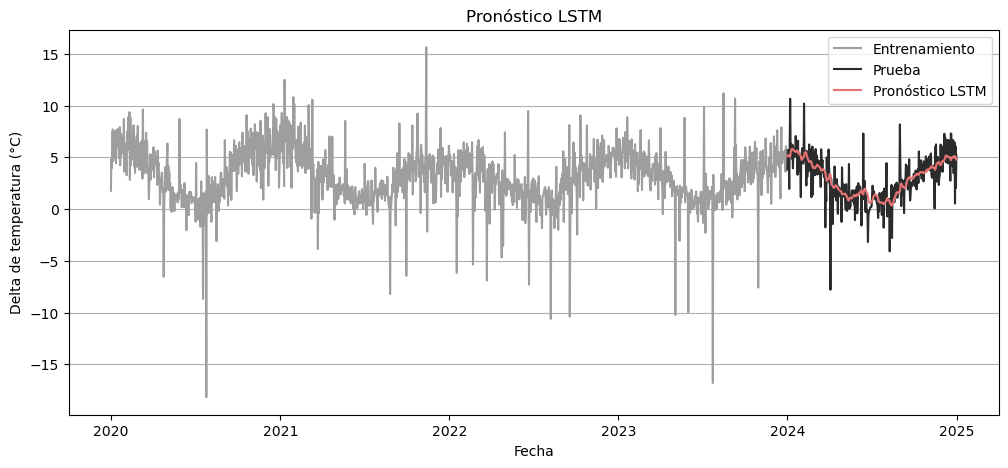

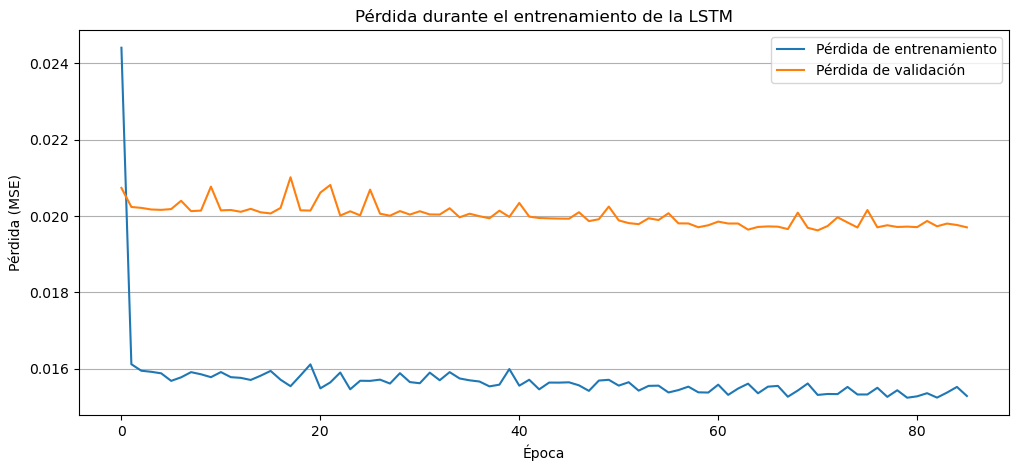

In [19]:

# Construir el modelo LSTM
input_shape = (seq_length, 3 if use_seasonal_features else 1)
model = Sequential([
    Input(shape=input_shape),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dense(1)
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1) 


In [ ]:
# Generar pronósticos
forecast_scaled = model.predict(X_test)

if use_seasonal_features:
    forecast_lstm = scaler.inverse_transform(
        np.concatenate([forecast_scaled, np.zeros((len(forecast_scaled), 2))], axis=1)
    )[:, 0]
else:
    forecast_lstm = scaler.inverse_transform(forecast_scaled)

test_index = df_serie.index[train_size:train_size + len(forecast_lstm)]
test_original = df_serie['delta'].iloc[train_size:train_size + len(forecast_lstm)]

# Visualizar resultados
plt.figure(figsize=(12, 5))
plt.plot(df_serie.index[:train_size], df_serie['delta'].iloc[:train_size], label='Entrenamiento', color=colores['train'])
plt.plot(test_index, test_original, label='Prueba', color=colores['test'])
plt.plot(test_index, forecast_lstm, label='Pronóstico LSTM', color=colores['LSTM'])
plt.title('Pronóstico LSTM')
plt.xlabel('Fecha')
plt.ylabel('Delta de temperatura (°C)')
plt.legend()
plt.grid(axis='y')
plt.show()

# Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento de la LSTM')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(axis='y')
plt.show()



In [ ]:
# Calcular métricas de error
mae = mean_absolute_error(test_original, forecast_lstm)
mse = mean_squared_error(test_original, forecast_lstm)
rmse = np.sqrt(mse)

guardar_estadisticas('LSTM',mae, mse, rmse)

### b) Transformer

In [153]:
# Crear secuencias para entrenamiento y prueba

# estos ya existen (los hice para LSTM)
train_data  = data_scaled[:train_size]
test_data  = data_scaled[train_size - seq_length:]

# Crea secuencias
seq_length = 16  # 16 dias
X_train, y_train = create_sequences(train_data, seq_length, target_idx=0)
X_test, y_test   = create_sequences(test_data,  seq_length, target_idx=0)

print(X_train.shape)
print(X_test.shape)

(1445, 16, 1)
(366, 16, 1)


In [154]:
class PositionalEncoding(layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model
        
        # Crea matriz de positional encoding (sinusoide fija)
        pe = np.zeros((seq_len, d_model))
        position = np.arange(0, seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[np.newaxis, ...]  # (1, seq_len, d_model)
        self.pe = tf.constant(pe, dtype=tf.float32)
    
    def call(self, inputs):
        return inputs + self.pe[:, :tf.shape(inputs)[1], :]


def build_transformer(d_model=64, n_heads=4, n_layers=2, ff_dim=128, dropout=0.1):

    seq_length = X_train.shape[1]
    n_features = X_train.shape[2]

    inputs = Input(shape=(seq_length, n_features))
    
    # 1. Proyección lineal a d_model
    x = layers.Dense(d_model)(inputs)
    
    # 2. POSITIONAL ENCODING
    x = PositionalEncoding(seq_length, d_model)(x)
    
    # 3. Bloques Transformer
    for _ in range(n_layers):
        # Multi-Head Self Attention
        attn_output = layers.MultiHeadAttention(
            num_heads=n_heads, key_dim=d_model//n_heads, dropout=dropout
        )(x, x)
        attn_output = layers.Dropout(dropout)(attn_output)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        # Feed Forward
        ff = layers.Dense(ff_dim, activation='relu')(x1)
        ff = layers.Dense(d_model)(ff)
        ff = layers.Dropout(dropout)(ff)
        x = layers.LayerNormalization(epsilon=1e-6)(x1 + ff)
    
    # 4. Salida
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1)(x)
    
    model = Model(inputs, outputs)
    return model


model = build_transformer(
    d_model=64,
    n_heads=4,
    n_layers=2,
    ff_dim=128,
    dropout=0.1
)


model.compile(
    optimizer=Adam(learning_rate=0.0012),
    loss='huber',
    # loss='mse',
    metrics=['mae']
)


model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20, # para probar, despues 100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 16, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_86 (Dense)    │ (None, 16, 64)    │        128 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 16, 64)    │          0 │ dense_86[0][0]    │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 16, 64)    │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_87          │ (None, 16, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_56 (Add)        │ (None, 16, 64)    │          0 │ positional_encod… │
│                     │                   │            │ dropout_87[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 64)    │        128 │ add_56[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_87 (Dense)    │ (None, 16, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_88 (Dense)    │ (None, 16, 64)    │      8,256 │ dense_87[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_88          │ (None, 16, 64)    │          0 │ dense_88[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_57 (Add)        │ (None, 16, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_88[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 64)    │        128 │ add_57[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 16, 64)    │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_90          │ (None, 16, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_58 (Add)        │ (None, 16, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_90[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 64)    │        128 │ add_58[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_89 (Dense)    │ (None, 16, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_90 (Dense)    │ (None, 16, 64)    │      8,256 │ dense_89[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 67,137 (262.25 KB)

 Trainable params: 67,137 (262.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.2864 - mae: 0.6159 - val_loss: 0.0136 - val_mae: 0.1140
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0149 - mae: 0.1311 - val_loss: 0.0151 - val_mae: 0.1249
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0138 - mae: 0.1197 - val_loss: 0.0189 - val_mae: 0.1583
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0155 - mae: 0.1347 - val_loss: 0.0122 - val_mae: 0.1051
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0110 - mae: 0.1090 - val_loss: 0.0095 - val_mae: 0.0741
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0110 - mae: 0.1089 - val_loss: 0.0128 - val_mae: 0.1060
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0124 - mae: 0.1122 - val_loss: 0.0099 - val_mae: 0.0804
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0099 - mae: 0.0999 - val_loss: 0.0096 - val_mae: 0.0741
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.01

In [155]:
# Generar pronósticos
forecast_scaled = model.predict(X_test)

if use_seasonal_features:
    forecast_transf = scaler.inverse_transform(
        np.concatenate([forecast_scaled, np.zeros((len(forecast_scaled), 2))], axis=1)
    )[:, 0]
else:
    forecast_transf = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).ravel()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


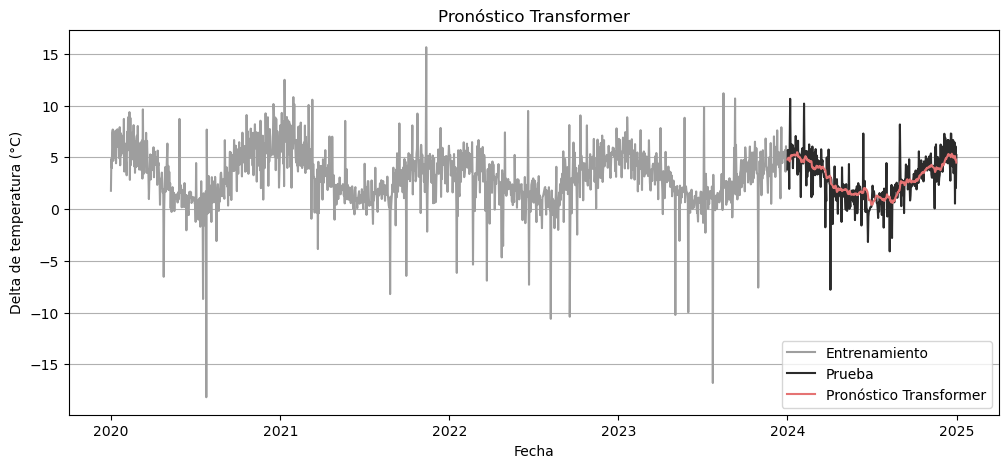

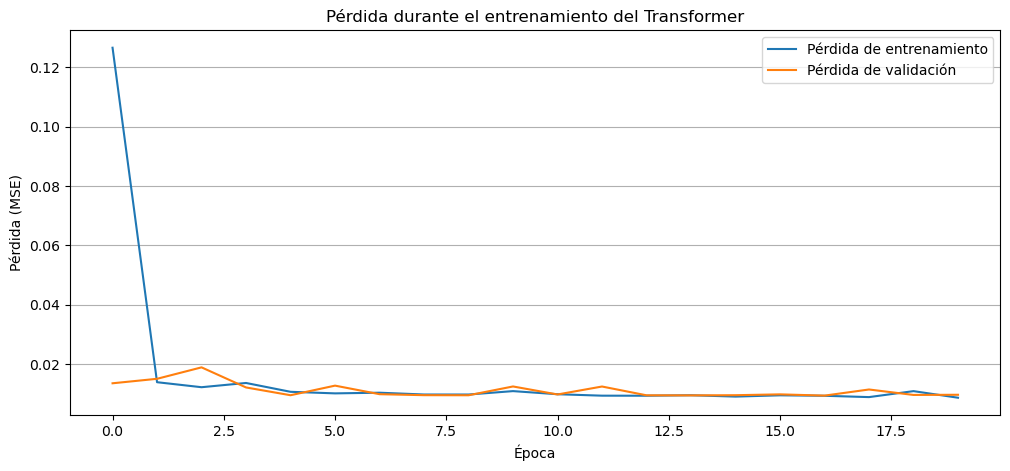

In [156]:

test_index = df_serie.index[train_size:train_size + len(forecast_transf)]
test_original = df_serie['delta'].iloc[train_size:train_size + len(forecast_transf)]

# Visualizar resultados
plt.figure(figsize=(12, 5))
plt.plot(df_serie.index[:train_size], df_serie['delta'].iloc[:train_size], label='Entrenamiento', color=colores['train'])
plt.plot(test_index, test_original, label='Prueba', color=colores['test'])
plt.plot(test_index, forecast_transf, label='Pronóstico Transformer', color=colores['LSTM'])
plt.title('Pronóstico Transformer')
plt.xlabel('Fecha')
plt.ylabel('Delta de temperatura (°C)')
plt.legend()
plt.grid(axis='y')
plt.show()

# Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento del Transformer')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(axis='y')
plt.show()


In [157]:
# Calcular métricas de error

mae = mean_absolute_error(test_original, forecast_transf)
mse = mean_squared_error(test_original, forecast_transf)
rmse = np.sqrt(mse)

guardar_estadisticas('TRANSFORMER',mae, mse, rmse)

### Pronósticos (para todos los modelos)

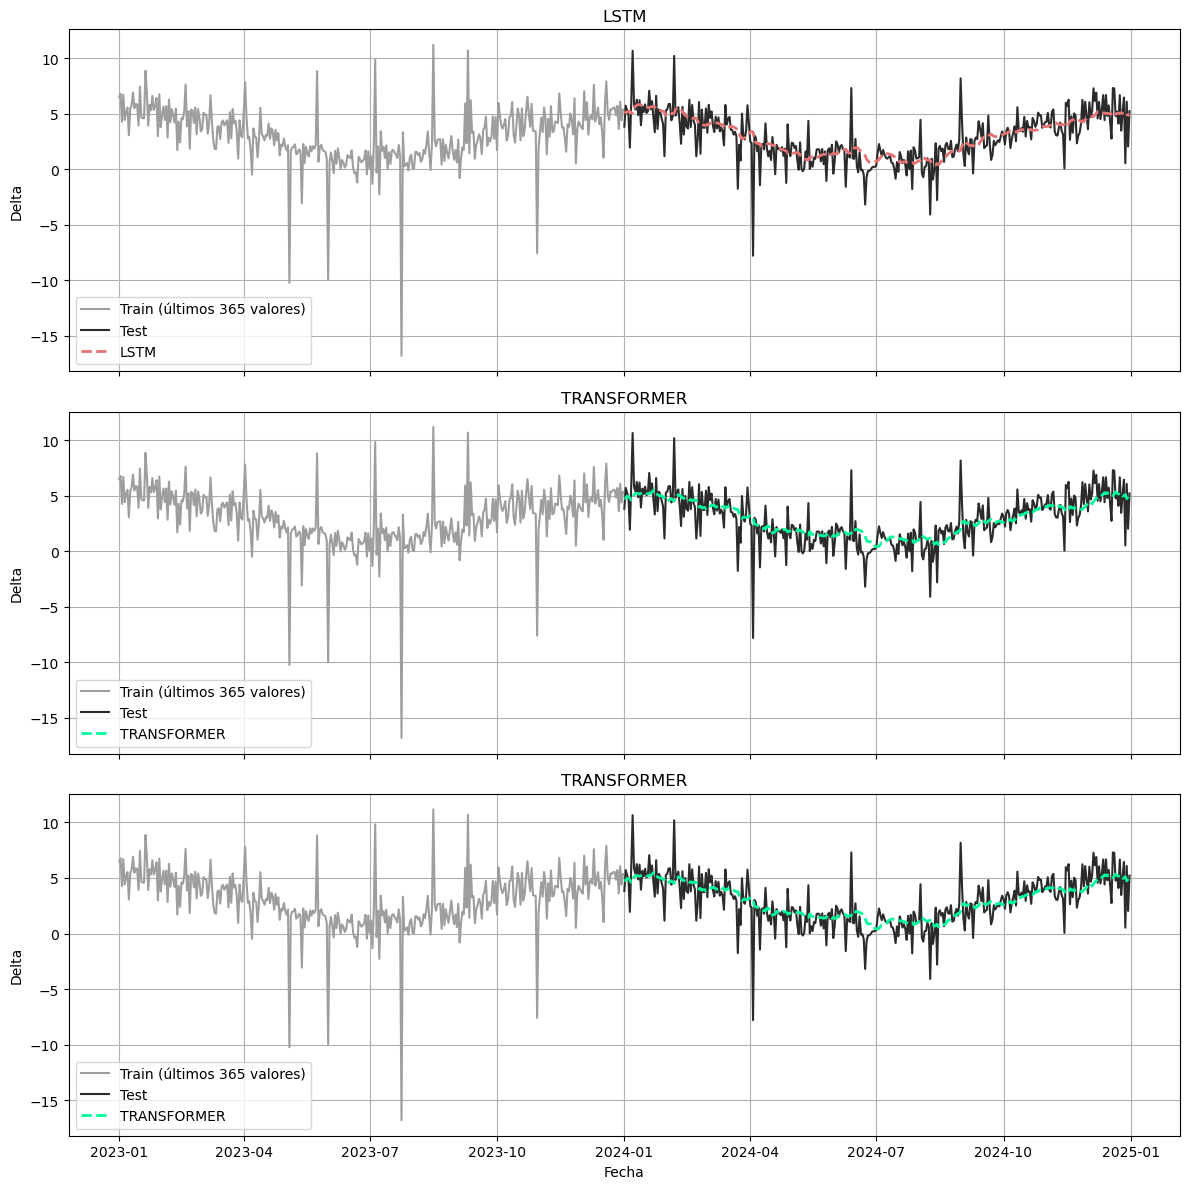

In [158]:
# Número de puntos históricos a mostrar
n_last = 365 # un año de datos
train_recent = train[-n_last:]

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=True)

# Lista de pronósticos y nombres
forecasts = [forecast_lstm, forecast_transf, forecast_transf]
names = ['LSTM', 'TRANSFORMER', 'TRANSFORMER'] # DESPUES REEMPLAZAR POR EL 3ER MODELO
colors = [colores['LSTM'], colores['TRANSFORMER'], colores['TRANSFORMER']]

for ax, forecast, name, color in zip(axes, forecasts, names, colors):
    # Plot train reciente
    ax.plot(train_recent.index, train_recent.values, label=f'Train (últimos {n_last} valores)', color=colores['train'])
    # Plot test
    ax.plot(test.index, test.values, label='Test', color=colores['test'])
    # Plot pronóstico
    ax.plot(test.index, forecast, label=name, linestyle='--', lw=2, color=color)

    ax.set_title(name)
    ax.set_ylabel('Delta')
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Fecha')
plt.tight_layout()
plt.show()


### Resultados

In [160]:
resultados = df_resultados.copy()
resultados.set_index('Modelo', inplace=True)
resultados

,MAE,MSE,RMSE
Modelo,,,
LSTM,1.045714,2.397659,1.548438
TRANSFORMER,1.063286,2.445530,1.563819


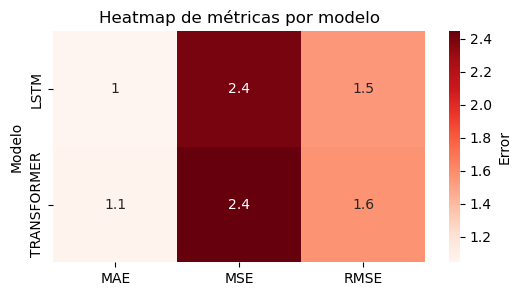

In [161]:
plt.figure(figsize=(6,3))
sns.heatmap(resultados, annot=True, cmap='Reds', cbar_kws={'label': 'Error'})
plt.title('Heatmap de métricas por modelo')
plt.show()


Para confirmar si las métricas son razonables, las comparamos en relación a las estadísticas de la variable delta:

In [162]:
Q1 = df_serie['delta'].quantile(0.25)
Q3 = df_serie['delta'].quantile(0.75)
IQR = Q3 - Q1
resultados['MAE_Relativo (%)'] = (resultados['MAE'] / IQR) * 100
resultados['RMSE_Relativo (%)'] = (resultados['RMSE'] / IQR) * 100

print(f'\nRango intercuartil de Delta: {IQR:.4f}\n')
resultados


Rango intercuartil de Delta: 3.2511



,MAE,MSE,RMSE,MAE_Relativo (%),RMSE_Relativo (%)
Modelo,,,,,
LSTM,1.045714,2.397659,1.548438,32.164984,47.628191
TRANSFORMER,1.063286,2.445530,1.563819,32.705480,48.101304
